# The Elbow Method

Certain data mining algorithms (including k-means clustering and k-nearest neighbors) require a user defined parameter *k*.  A user of these algorithms is required to select this value, which raises the questions: what is the "best" value of *k* that one should select to solve their problem?

This mini-episode explores the appropriate value of *k* to use when trying to estimate the cost of a house in Los Angeles based on the closests sales in it's area.

In [378]:
%matplotlib inline
import os
import json
import pickle
import geocoder
import math
import random
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

In [3]:
addresses = {}

In [4]:
root = '../data/'
allfiles = []
dirs = os.listdir(root)
for d in dirs:
    files = os.listdir(root + d)
    for f in files:
        allfiles.append(root + d + '/' + f)

In [544]:
random.shuffle(allfiles)
len(allfiles)

166212

In [45]:
def persist(addresses):
    save = {}
    for key in addresses.keys():
        addr = addresses[key]
        val = addr.latlng
        val.append(addr.accuracy)
        save[key] = val
    #
    h = open('addresses.pkl', 'wb')
    pickle.dump(save, h)
    h.close()

In [120]:
def flatten(sarr):
    if type(sarr) == str or type(sarr) == unicode:
        return sarr
    res = ''
    for s in sarr:
        s = s.strip()
        if len(s) > 0:
            if len(res) > 0:
                res += s + ', '
            else:
                res = s
    return res

In [314]:
def numClean(x):
    if x is None:
        return None
    if x == '':
        return None
    if type(x) == float:
        return x
    try:
        return float(x.replace('$', '').replace(',', ''))
    except ValueError:
        return None

In [306]:
def clean_details(details, blockLLMap):
    c = 0
    details['Legals'] = flatten(details['Legals'])
    if details.has_key('Improvements'):
        di = details['Improvements']
        if len(di)>0:
            imps = di[0]
            for key in imps.keys():
                val = imps[key]
                details['improve_' + key] = val
            del details['Improvements']
        convertFields = ['SalePrice', 'FIXEVEV', 'FIXTVAL', 'HOEVAL', 'IMPROVAL', 'LANDVAL', 'PPEXEVAL', 'PPVALUE', 'REEXEVAL', 'improve_BDLBATH', 'improve_BDLBDRM', 'improve_BDLEFFYR', 'improve_BDLSQMAIN', 'improve_BDLUNITS', 'improve_BDLYRBLT']
        for cf in convertFields:
            if details.has_key(cf):
                details[cf] = numClean(details[cf])
    head = int(details['AIN'])/1000 * 1000 + 1
    try:
        ll = blockLLMap[head]
        details['latitude'] = ll.lat
        details['longitude'] = ll.lng
    except KeyError:
        return details
    return details

I'm far from being an expert on these AIN numbers, but it's clear there's some order to them.  For my application, I'm comfortable saying that every parcel on the same block can be considered to have a distance of 0.  This will save me the pain of trying to geocode hundreds of thousands of addresses.  I might later work on putting some offset in based on the data I already have.  For now, let's grab every AIN that appears to be at the "head" of a block.

In [152]:
errcount = 0
c = 0
blockLLMap = {}
alldetails = []
for f in allfiles:
    try:
        data = json.loads(pickle.load(open(f, 'r')).text)
        details = data['results']['ParcelDetails']
        if details:
            if int(details['AIN']) % 1000 == 1:
                addr = details['Address1'] + ' ' + details['Address2']
                try:
                    loc = addresses[addr]
                    c += 1
                except KeyError:
                    print 'Lookup', addr
                    loc = geocoder.google(addr)
                    addresses[addr] = loc
                blockLLMap[int(details['AIN'])] = loc
                if c % 1000 == 0:
                    print 'Completed', 100.0 * c / len(allfiles), errcount
            alldetails.append(details)
    except:
        print 'Error on: ', f
        errcount += 1
        if errcount>10:
            break

# Since I did a bunch of slow API lookups, let's cache this in case I want to use it again in the future.
persist(addresses)

Error on:  ../data/old/addresses.pkl.pkl
Completed 0.601641277405 1
Completed 1.20328255481 1
Completed 1.80492383221 1


In [214]:
# Do data cleaning
errcount = 0
c = 0
all2 = []
for details in alldetails:
    details = clean_details(details, blockLLMap)
    all2.append(details)

df = pd.DataFrame(all2)

In [254]:
# See how many latitudes are missing given my assumption
df['latitude'].apply(lambda x: math.isnan(x)).sum()

63045

There are enough lat/lngs missing that I want to fill in some of the blanks.  Luckily, there's a lot but it's manageable with a long running script.

In [ ]:
c=0
gaps = df[df['latitude'].apply(lambda x: math.isnan(x))]
print gaps.shape
for r in range(gaps.shape[0]):
    row = gaps.iloc[r]
    addr = row['Address1'] + ' ' + row['Address2']
    try:
        loc = addresses[addr]
        c += 1
    except KeyError:
        print 'Lookup', addr
        loc = geocoder.google(addr)
        addresses[addr] = loc
    blockLLMap[int(details['AIN'])] = loc
    if c % 1000 == 0:
        print 'Completed', 100.0 * r / gaps.shape[0], errcount

In [225]:
df['AIN'] = df['AIN'].astype(int)

In [226]:
# save df to csv
df.to_csv('details.csv', sep='\t', index=False, encoding='utf-8')

In [ ]:
# all on block are considered 0

In [545]:
# Sample of the data
df.head()

,AIN,Address1,Address2,Assr_Index_Map,Assr_Map,CLUSTER,FIXEVEV,FIXTVAL,FormattedAIN,HOEVAL,...,UseType_Label,improve_BDLBATH,improve_BDLBDRM,improve_BDLEFFYR,improve_BDLSQMAIN,improve_BDLUNITS,improve_BDLYRBLT,improve_ImprovementNum,latitude,longitude
0,4252019010,3741 VETERAN AVE,LOS ANGELES CA 90034,None,None,09156,0,0,4252-019-010,7000,...,Single Family Residential,1,2,1950,905,1,1950,1,NaN,NaN
1,4330028006,400 S BEVERLY DR,BEVERLY HILLS CA 90212,None,None,23620,0,0,4330-028-006,0,...,Commercial / Industrial,0,0,1970,45326,0,1957,1,NaN,NaN
2,4277013052,"933 21ST ST, APT 0013",SANTA MONICA CA 90403,None,None,07398,0,0,4277-013-052,7000,...,Condominium,3,2,1974,1254,1,1974,1,34.036635,-118.486177
3,4317009025,2006 THAYER AVE,LOS ANGELES CA 90025,None,None,07153,0,0,4317-009-025,7000,...,Single Family Residential,3,4,1960,2111,1,1925,1,34.049540,-118.425438
4,4249026288,,,None,None,22811,0,0,4249-026-288,0,...,Vacant Land,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [266]:
df.shape

(148557, 36)

In [546]:
# Filter down to those I have a price for

f1 = df['SalePrice'] > 0
f1 = df['SalePrice'] > 0
f2 = df['latitude'].apply(lambda x: not(math.isnan(x)))
df2 = df[f1 & f2]
print 'Remaining after filter:', 1.0 * df2.shape[0] / df.shape[0]
print df2.shape[0]

Remaining after filter: 0.0380594653904
5654


I have a disappointingly small subset, but let's see if we can make the most of it.

So I'm using Euclydian distance, which is strictly incorrect.  I should be using the geodesic distance, since the curvature of the Earth, especially at the longitude of Los Angeles, will introduce significant error in the Euclydian distance approximation.  Since i'm looking for the *nearest* neighbors, this error might be minimized, but I'm not sure if it will be trivial.  Yet, I'm skipping this step for now, since the objective in this particular mini-episode is to talk about the Elbow Method, not about [distance measures](http://dataskeptic.com/epnotes/ep71_distance-measures.php).

In [344]:
# load to k-d tree
lat = df2['latitude']
lng = df2['longitude']
df2.index = np.arange(df2.shape[0]) # Just to make sure the index is useful to us
k=2
kdt = cKDTree(zip(lat,lng))

In [540]:
maxk = 25

In [541]:
# iterate over k, calculate average price, store mean and accuracy
results = []
for k in range(1, maxk):
    for r in np.arange(df2.shape[0]):
        row = df2.iloc[r]
        sp = row['SalePrice']
        distances, neighbors = kdt.query((row['latitude'], row['longitude']), k=k)
        if type(distances) == float:
            distances = pd.Series(distances)
        if type(neighbors) == int:
            neighbors = pd.Series(neighbors)
        if sum(neighbors==r):
            selfidx = np.where(neighbors == r)[0][0]
            neighbors = pd.Series(neighbors)
            neighbors.drop(selfidx, inplace=True)
        avg_dist = distances.mean()
        #avg_sp = df2.iloc[neighbors]['SalePrice'].mean()
        avg_sp = math.sqrt(sum((sp - df2.iloc[neighbors]['SalePrice']).apply(lambda x: math.pow(x, 2))))
        result = [sp, k, avg_dist, avg_sp, len(neighbors)]
        results.append(result)

In [542]:
rdf = pd.DataFrame(results)
rdf.columns = ['SalePrice', 'k', 'adist', 'avgNeighborSalePrice', 'numNeighbors']

# There are some extreme outliers, so let's trim the top and bottom
low, high = rdf['SalePrice'].quantile([.05, .95]).tolist()
rdf = rdf[rdf['SalePrice'] > low]
rdf = rdf[rdf['SalePrice'] < high]
rdf['delta'] = rdf['avgNeighborSalePrice'] - rdf['SalePrice']
rdf['sq_err'] = rdf['delta'].apply(lambda x: abs(x))
low, high = rdf['delta'].quantile([.05, .95]).tolist()
rdf = rdf[rdf['delta'] > low]
rdf = rdf[rdf['delta'] < high]
gb = rdf.groupby('k')['sq_err'].mean()

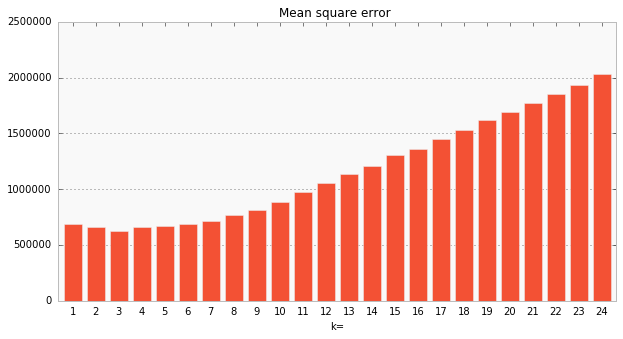

In [543]:
plt.figure(figsize=(10,5))
plt.bar(gb.index, gb)
plt.xlabel('k=')
plt.gca().xaxis.grid(False)
plt.title('Mean square error ')
plt.xticks(gb.index + 0.4, gb.index)
plt.xlim(.75, maxk)
plt.show()

The figure above plots the mean square error of the price of a home to it's k nearest neighbors.  Naturally, this diverges as k increases, because it means we're searching further and further away from the home for comparables, which means homes that are less comparable in terms of location.

Yet, we find a small minimium with k=3, which would imply that the optimal number of nearest neighbors to use to estimate the price of a home based *strictly* on price alone, is three.

The reader should be a bit skeptical of this result, because we have some unstated assumptions about the data.  First, we assume the data source is good.  Yet, it's a questionable usage.  I got it by crawling an unpublicized API of the assessor's office.  It clearly has large gaps (homes without recent sale prices).  I have no explanation for these gaps.  If they were random ommisions, that would not be so bad, but I suspect their introducing a bias to the dataset.

I also don't account for trend or seasonality.  Because my dataset got down to be rather small compared to the total population of homes in LA, I used all the data.  In reality, more recent data would be better (perhaps the last 3 years?).  Additionally, home sales have seasonal components that I didn't account for.  Thus, the nearest neigbors might have all sold during a more favorable time in the market, and are thus, not exactly comparable to the home I'm estimating.

I'm also only comparing on price.  Euclydian distance (which has it's own problems stated above) is the only metric.  A one bedroom condo might be compared to a 4 bedroom single family dettached home by this method, if it happens to be closest.  This is clearly not ideal and will introduce a significant amount of variance into my results.

So where is the elbow?  Well, it's arguable at k=3.  One might say this is not actually an "elbow method" problem because this method is typically used for monotonically decreasing trade-offs.  In this way the more common use in k-means clustering would have been a better example.  For a discussion of the more ideal use cases, please listen to this episode.

Lastly, consider these show notes an demonstration of technology and technique over actual result.  There are many things to be skeptical of in this analysis, but I learned a few things a long the way that will go into our upcoming home purchase decisions.